# Explication de VGG19 
Nous faisons l'explication de l'architecture de réseau de neurones convolutifs (CNN) VGG (Visual Geometry Group) avec des valeurs de SHAP issues d'un Gradient Explainer.

In [18]:
import json 
import torch
import os
import torchvision 
from PIL import Image
from torchvision.transforms import v2
from torchvision import models
import shap 
import numpy as np
import matplotlib.pyplot as plt
import shap.benchmark as benchmark

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input

Input image shape: (1, 224, 224, 3)


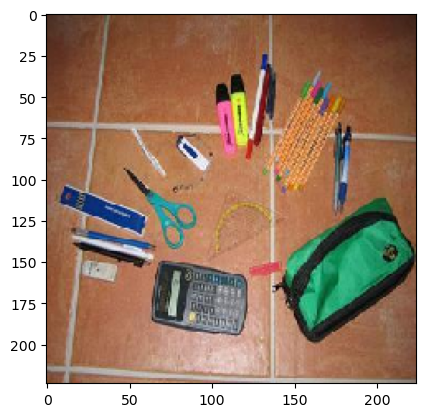

In [19]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

def normalize(image):
    if image.max() > 1:
        image /= 255
    image = (image - mean) / std
    # in addition, roll the axis so that they suit pytorch
    return torch.tensor(image.swapaxes(-1, 1).swapaxes(2, 3)).float()

img_path = "../../data/images/Trousse.jpg"
#img_path = "../data/Dog-Cat.jpg"
  
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
#x = preprocess_input(x)
print('Input image shape:', x.shape)

plt.imshow(img)


In [20]:
# load the pre-trained vgg19 model, using 'image-net' set of weights
# it was trained on vgg19 dataset
model = models.vgg19(weights=models.VGG19_Weights.DEFAULT)

# Set the model to evaluation mode (no training)
model.eval()

# Load imagenet dataset (50 images aléatoires ainsi que leurs labels)
X,y = shap.datasets.imagenet50()

# Normaliser les valeurs des pixels 
X /= 255

# Selections des images pour l'explication (index 1 et 2)
#to_explain = X[[1,2,5]]
to_explain = x


In [21]:
# Récupérer les noms des classes d'ImageNet
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)  # Mise en cache du fichier si absent
with open(fname) as f:
    class_names = json.load(f)  # charger les noms de classes à partir du fichier JSON 

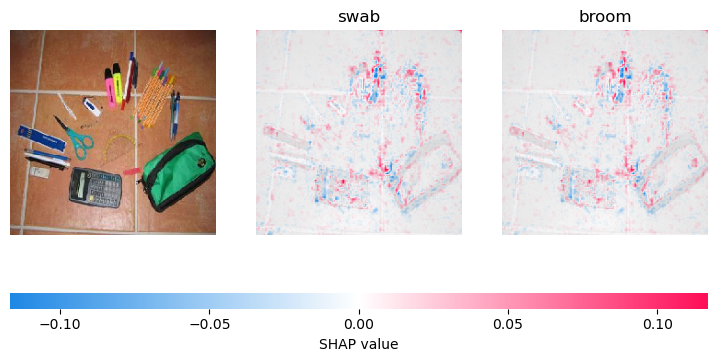

In [22]:
# Création d'un GradientExplainer, avec la 7eme couche du model pour expliquer la prédiction
e = shap.GradientExplainer((model, model.features[7]), normalize(to_explain))

# Calcul des valeurs de SHAP et des indices pour l'explication des images choisies
# mettre plus de samples
shap_values, indexes = e.shap_values(
    normalize(to_explain), ranked_outputs=2, nsamples=2
)

# Noms des classes correspondant aux indices obtenus pour les images choisies
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# Organisation des valeurs de shap pour le graph 
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

# Afficher l'explication (Valeurs SHAP) avec les images et leur label de classe 
shap.image_plot(shap_values, to_explain, index_names)

In [28]:
# Création d'un PARTITION, avec la 7eme couche du model pour expliquer la prédiction
masker = shap.maskers.Image("inpaint_telea", to_explain.shape)

def f(x):
    return model(x)

e = shap.Explainer(f, masker, normalize(to_explain))

shap_values = e(
    normalize(to_explain), max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:4]
)

index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# Organisation des valeurs de shap pour le graph 
shap_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shap_values]

# Afficher l'explication (Valeurs SHAP) avec les images et leur label de classe 
shap.image_plot(shap_values, to_explain, index_names)

TypeError: The passed link function needs to be callable!

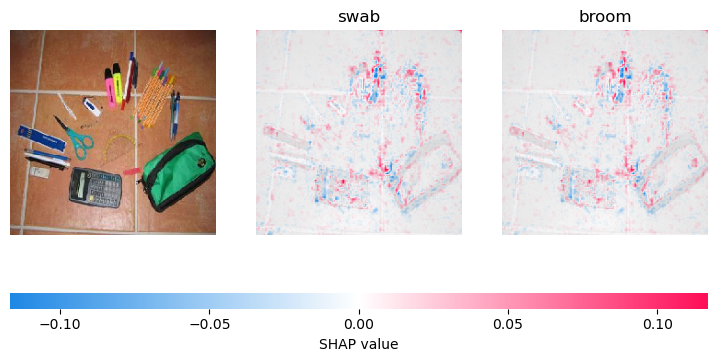

<Figure size 640x480 with 0 Axes>

In [44]:
shap.image_plot(shap_values, to_explain, index_names)
# Save the plot as an image
plt.savefig('shap_summary_plot.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


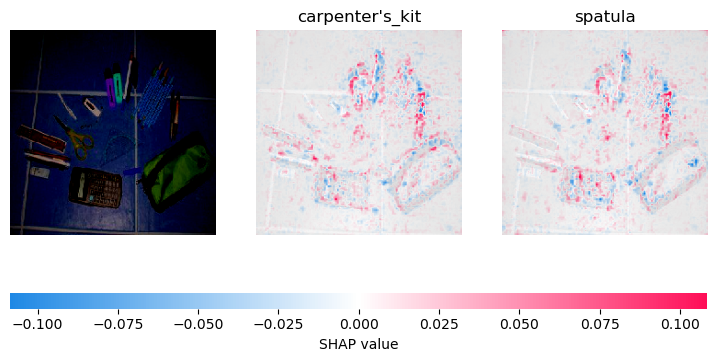

TypeError: The shap_values arg looks multi output, try `shap_values[i]` instead.

In [14]:
shap.image_plot(shap_values, to_explain, index_names)

# Save the plot as an image directly using the SHAP library
